# 🔵 **Dependencies**




In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
#for windows
!pip install -q soundfile
#for linux
!pip install -q sox

In [ ]:
!pip install -q librosa

In [ ]:
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 788.4 kB/s eta 0:00:00


# 🔵 **Imports**

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines

from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torchvision import models as extractor


import numpy  as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchmetrics as tm
import tqdm
import librosa
from collections import Counter

from IPython.display import Audio

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchaudio, torchtext, pd, tm, librosa]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchaudio --> 2.1.0+cu118
torchtext --> 0.16.0+cpu
pandas --> 1.5.3
torchmetrics --> 1.2.1
librosa --> 0.10.1


# 🔵 **Utils**

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
def to_sentence(preds, inputs):
  sentences_preds = []
  for pred in preds:
    indexes = pred.argmax(dim = -1).tolist()
    sentence = [ch_vocab.get_itos()[index] for index in indexes]
    sentence = ''.join(sentence).replace('<sos>', '')
    sentence = sentence.replace('<eos>', '')
    sentence = sentence.replace('<pad>', '')
    sentences_preds.append(''.join(sentence))

  sentences_inputs = []
  for input in inputs:
    indexes = input.tolist()
    sentence = [ch_vocab.get_itos()[index] for index in indexes]
    sentence = ''.join(sentence).replace('<sos>', '')
    sentence = sentence.replace('<eos>', '')
    sentence = sentence.replace('<pad>', '')
    sentences_inputs.append(sentence)

  return sentences_preds, sentences_inputs

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange


class CTCLoss(nn.Module):
    """Convenient wrapper for CTCLoss that handles log_softmax and taking input/target lengths."""

    def __init__(self, blank: int = 0) -> None:
        """Init method.

        Args:
            blank (int, optional): Blank token. Defaults to 0.
        """
        super().__init__()
        self.blank = blank

    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Forward method.

        Args:
            preds (torch.Tensor): Model predictions. Tensor of shape (batch, sequence_length, num_classes), or (N, T, C).
            targets (torch.Tensor): Target tensor of shape (batch, max_seq_length). max_seq_length may vary
                per batch.

        Returns:
            torch.Tensor: Loss scalar.
        """
        preds = preds.log_softmax(-1)
        batch, seq_len, classes = preds.shape
        preds = rearrange(preds, "n t c -> t n c") # since ctc_loss needs (T, N, C) inputs
        # equiv. to preds = preds.permute(1, 0, 2), if you don't use einops

        pred_lengths = torch.full(size=(batch,), fill_value=seq_len, dtype=torch.long)
        target_lengths = torch.count_nonzero(targets, axis=1)

        return F.ctc_loss(preds, targets, pred_lengths, pred_lengths, blank=self.blank, zero_infinity=True)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [ ]:
def print_stats(waveform, sample_rate = None, src = None):
  if src:
    print("_" * 10)
    print("Source:", src)
    print("_" * 10)

  if sample_rate:
    print("Sample Rate: ", sample_rate)

  print('Shape: ', tuple(waveform.shape))
  print('DType: ', waveform.dtype)
  print(f" - Max:   {waveform.max().item():6.3f}")
  print(f" - Min:   {waveform.min().item():6.3f}")
  print(f" - Mean:   {waveform.mean().item():6.3f}")
  print(f" - Std Dev:   {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [ ]:
def plot_waveform(waveform, sample_rate, title = 'Waveform', xlim = None, ylim = None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth = 1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channels {c + 1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block = False)

In [ ]:
def plot_spectrogram(specgram, title = None, ylabel = 'freq_bin'):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(T.AmplitudeToDB()(specgram), origin = 'lower')
  fig.colorbar(im, ax = axs)
  plt.show(block = False)

# 🔵 **Dataset**

## 🔵 **LoadDataset**

In [ ]:
dataset = datasets.LJSPEECH('/content/', 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2', download = True)

100%|██████████| 2.56G/2.56G [00:34<00:00, 78.9MB/s]


In [ ]:
len(dataset)

13100

In [ ]:
import csv
with open('/content/LJSpeech-1.1/metadata.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    file = []
    for row in spamreader:
        file.append(' '.join(row))

In [ ]:
csv_dataset = []
for sen in file:
  sent = sen.split('|')
  csv_dataset.append([sent[0], sent[1]])

In [ ]:
data_df = pd.DataFrame(csv_dataset, columns = ['id', 'text'])
data_df

,id,text
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
...,...,...
13095,LJ050-0274,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...


In [ ]:
class SplitData():
  def __init__(self, data_path):
    super(SplitData, self).__init__()
    data = np.loadtxt(data_path, dtype = str).tolist()
    self.ids = []
    for name in data:
      id = data_df[data_df['id'] == name].index.item()
      self.ids.append(id)

  def __call__(self, idx):
    return dataset[self.ids[idx]]

  def __len__(self):
    return len(self.ids)

In [ ]:
train_set = SplitData('train.txt')
valid_set = SplitData('valid.txt')
test_set  = SplitData('test.txt')

In [ ]:
len(train_set), len(valid_set), len(test_set)

(12500, 100, 500)

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
sentences = []
for i in range(len(train_set)):
  sentences.append(train_set(i)[2])

In [ ]:
train_tokens = tokenizer(' '.join(sentences))
len(train_tokens)

238961

In [ ]:
train_tokens[0:20]

['it',
 'has',
 'used',
 'other',
 'treasury',
 'law',
 'enforcement',
 'agents',
 'on',
 'special',
 'experiments',
 'in',
 'building',
 'and',
 'route',
 'surveys',
 'in',
 'places',
 'to',
 'which']

In [ ]:
vocab  = build_vocab_from_iterator([train_tokens], min_freq = 0, specials = ['<unk>', '<pad>' ,'<sos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])
vocab_size = len(vocab.get_itos())
vocab_size

14420

In [ ]:
token_list = vocab.get_itos()
characters = []
for token in token_list:
    chrc = list(token)
    for ch in chrc:
      characters.append(ch)

len(characters)

110573

In [ ]:
ch_vocab  = build_vocab_from_iterator([characters], min_freq = 0, specials = ['<unk>', '<pad>' ,'<sos>', '<eos>', ' '])
ch_vocab.set_default_index(ch_vocab['<unk>'])
ch_vocab_size = len(ch_vocab.get_itos())
ch_vocab_size

65

## 🔵 **EDA**

In [ ]:
l_sentences = []
for sentence in sentences:
  l_sentences.append(len(tokenizer(sentence)))

In [ ]:
L_df = pd.DataFrame(l_sentences, index = sentences, columns = ['L'])
L_df

In [ ]:
L_df.describe()

In [ ]:
word_counts = Counter()
for word in train_tokens:
    word_counts.update([word])

In [ ]:
N_word = pd.DataFrame(word_counts.values(), index = word_counts.keys(), columns = ['N']).sort_values('N')
N_word.describe()

In [ ]:
plt.boxplot(N_word)
plt.show()

In [ ]:
N_word[N_word['N']>5000]

In [ ]:
N_word[N_word['N']<2]

In [ ]:
waveform, sample_rate, text, _  = train_set(0)

In [ ]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
mel_spectro = T.MelSpectrogram(sample_rate, n_fft = 1024, hop_length = 128, n_mels = 150)
spec = mel_spectro(waveform)

In [ ]:
plot_spectrogram(spec[0])

In [ ]:
text

In [ ]:
Audio(waveform.numpy(), rate = sample_rate)

In [ ]:
wav_info = []
for i in range(len(train_set)):
  sample, sample_rate, _, _  = train_set(i)
  wav_info.append([sample.shape[1]/sample_rate, sample.mean().item(), sample.std().item()])

In [ ]:
wav_df = pd.DataFrame(wav_info, columns = ['time', 'mean', 'std'])
wav_df.describe()

### average mean = 0.000009 ||| average std = 0.066083

## 🔵 **CustomDataset**




In [ ]:
transform = nn.Sequential(T.MelSpectrogram(sample_rate = 22050, n_fft = 512, hop_length = 128, n_mels = 30),
                          T.FrequencyMasking(freq_mask_param = 20),
                          T.TimeMasking(time_mask_param = 200))

In [ ]:
class LJSpeechDataset(Dataset):
  def __init__(self, dataset, tokenizer, vocab, transform = None):
    super(LJSpeechDataset, self).__init__()
    self.dataset   = dataset
    self.tokenizer = tokenizer
    self.vocab     = vocab
    self.transform = transform

  def __getitem__(self, idx):
    wavform, sample_rate, text, _ = self.dataset(idx)

    if self.transform:
      input = self.transform(wavform)
    else:
      input = T.MelSpectrogram(sample_rate, n_fft = 256, hop_length = 256, n_mels = 30)(wavform)

    characters = list(text)
    characters.append('<eos>')
    characters.insert(0, '<sos>')
    text_idx = [self.vocab[character.lower()] for character in characters]
    target   = torch.LongTensor(text_idx)

    return input, target

  def __len__(self):
    return len(self.dataset)

In [ ]:
train_dataset = LJSpeechDataset(train_set, tokenizer, ch_vocab, None)
valid_dataset = LJSpeechDataset(valid_set, tokenizer, ch_vocab, None)
test_dataset  = LJSpeechDataset(test_set, tokenizer , ch_vocab, None)

In [ ]:
spec, taregt = train_dataset[0]
spec.shape, taregt

(torch.Size([1, 30, 850]),
 tensor([ 2,  6, 11,  4, 20, 10,  7,  4, 16,  7,  5, 14,  4, 12, 11, 20,  5,  9,
          4, 11,  9,  5, 10,  7, 16,  9, 22,  4, 13, 10, 25,  4,  5,  8, 23, 12,
          9, 15,  5, 19,  5,  8, 11,  4, 10, 18,  5,  8, 11,  7,  4, 12,  8,  4,
          7, 17,  5, 15,  6, 10, 13,  4,  5, 28, 17,  5,  9,  6, 19,  5,  8, 11,
          7,  4,  6,  8,  4, 21, 16,  6, 13, 14,  6,  8, 18,  4, 10,  8, 14,  4,
          9, 12, 16, 11,  5,  4,  7, 16,  9, 24,  5, 22,  7,  4,  6,  8,  4, 17,
         13, 10, 15,  5,  7,  4, 11, 12,  4, 25, 20,  6, 15, 20,  4, 11, 20,  5,
          4, 17,  9,  5,  7,  6, 14,  5,  8, 11,  4, 23,  9,  5, 32, 16,  5,  8,
         11, 13, 22,  4, 11,  9, 10, 24,  5, 13,  7, 57,  3]))

## 🔵 **Visualize**

In [ ]:
import random
def visualize_random_sample(n, dataset, vocab):

  n_random_idx = random.sample(range(0, len(dataset) - 1), n)

  audios = []
  texts  = []
  for idx in n_random_idx:

      spec, text_idx = dataset[idx]
      wavform = T.InverseMelScale(n_stft = 256, n_mels = 30, sample_rate = 22050)(spec[0])
      audios.append(Audio(wavform, rate = 22050))
      display(plot_spectrogram(spec[0]))
      display(Audio(wavform, rate = 22050))


      text = [vocab.get_itos()[index] for index in text_idx.tolist()]
      texts.append(text)
      print(''.join(text))

  return audios, texts

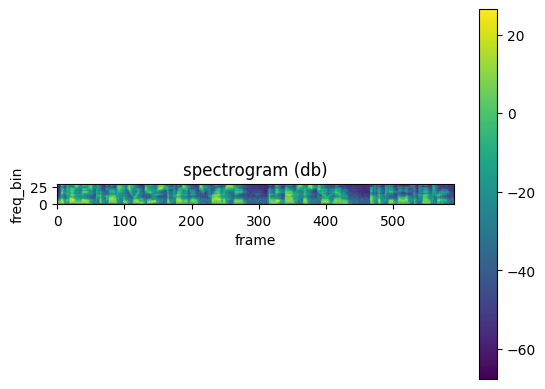

None

<sos>because these precautions reduce the president's privacy and the access to him of the people of the country.<eos>


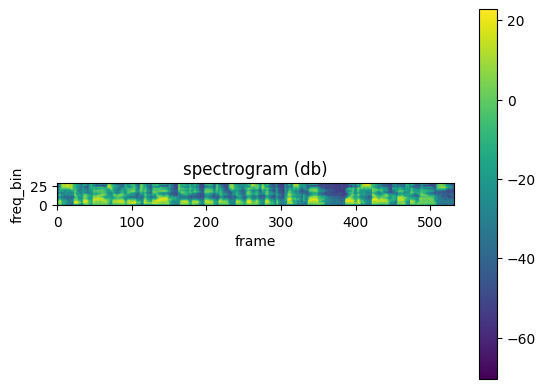

None

<sos>the supervisor of each of the off-duty agents who visited the press club or the cellar coffee house<eos>


In [ ]:
audios, texts = visualize_random_sample(2, train_dataset, ch_vocab)

## 🔵 **DataLoader**

In [ ]:
def collate_fn(batch):
  samples = [b[0][0].t() for b in batch]
  samples = pad_sequence(samples, batch_first = True).unsqueeze(1)
  targets  = [b[1] for b in batch]
  targets  = pad_sequence(targets, batch_first = True, padding_value = vocab['<pad>'])

  return samples, targets

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle = False, collate_fn = collate_fn)
test_loader  = DataLoader(test_dataset , batch_size = 16, shuffle = False, collate_fn = collate_fn)

In [ ]:
input, target = next(iter(train_loader))

In [ ]:
input.shape, target.shape

(torch.Size([16, 1, 772, 30]), torch.Size([16, 148]))

# 🔵 **Model**

In [ ]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
class Speech2Text(nn.Module):
  def __init__(self, num_encoder_layer, num_decoder_layer, nhead, dim_forward, dropout, batch_first,
               vocab_size, embedding_dim, c = 8):
    super(Speech2Text, self).__init__()

    self.embedding_dim = embedding_dim
    self.pos_encoder = PositionalEncoding(embedding_dim, dropout)

    self.feature_extractor = nn.Sequential(nn.Conv2d(1, c, (3, 3), stride = (2, 2), padding = (1, 1)),
                                           nn.ReLU(),
                                           nn.BatchNorm2d(c),
                                           nn.Conv2d(c, c * 2, (3, 3), stride = (2, 2), padding = (1, 1)),
                                           nn.ReLU(),
                                           nn.BatchNorm2d(c * 2),
                                           nn.Conv2d(c * 2, c * 4, (3, 3), stride = (2, 2), padding = (1, 1)),
                                           nn.ReLU(),
                                           nn.BatchNorm2d(c * 4),
                                           nn.AdaptiveAvgPool2d(output_size = (1, 1)),
                                           nn.Flatten(1),
                                           nn.Linear(c * 4, embedding_dim))

    self.transformer = nn.Transformer(embedding_dim, nhead, num_encoder_layer, num_decoder_layer, dim_forward, dropout, batch_first = batch_first)

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.fc = nn.Linear(embedding_dim, vocab_size)

  def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

  def forward(self, audio, tokens):
    y = self.Encoder(audio)
    y = self.Decoder(y, tokens)
    y = self.fc(y)
    return y

  def Encoder(self, audio):
    y = self.feature_extractor(audio)
    y = self.transformer.encoder(y)

    return y

  def Decoder(self, encoder_out, tokens):
    y = self.embedding(tokens) * math.sqrt(self.embedding_dim)
    y = self.pos_encoder(y)
    tgt_mask = self.transformer.generate_square_subsequent_mask(y.shape[1])
    y = self.transformer.decoder(y, encoder_out.unsqueeze(1),tgt_mask = tgt_mask)

    return y

In [ ]:
model = Speech2Text(1, 1, 1, 10, 0.1, True, ch_vocab_size, 10).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
num_trainable_params(model)

0.009595

In [ ]:
audio, tokens = next(iter(train_loader))

In [ ]:
audio.shape, tokens.shape

(torch.Size([16, 1, 829, 30]), torch.Size([16, 150]))

In [ ]:
model(audio.to(device), tokens[:, 0:-1].to(device)).shape

torch.Size([16, 149, 65])

# 🔵 **Model2**

In [ ]:
class Speech2Text2(nn.Module):
  def __init__(self, nhead, dim_forward, dropout, batch_first,
               vocab_size, embedding_dim, c = 8):
    super(Speech2Text2, self).__init__()

    self.embedding_dim = embedding_dim
    self.pos_encoder = PositionalEncoding(embedding_dim, dropout)

    self.feature_extractor = nn.Sequential(nn.Conv2d(1, c, (3, 3), stride = (2, 2), padding = (1, 1)),
                                           nn.ReLU(),
                                           nn.BatchNorm2d(c),
                                           nn.Conv2d(c, c * 2, (3, 3), stride = (2, 2), padding = (1, 1)),
                                           nn.ReLU(),
                                           nn.BatchNorm2d(c * 2),
                                           nn.Conv2d(c * 2, c * 4, (3, 3), stride = (2, 2), padding = (1, 1)),
                                           nn.ReLU(),
                                           nn.BatchNorm2d(c * 4),
                                           nn.AdaptiveAvgPool2d(output_size = (1, 1)),
                                           nn.Flatten(1),
                                           nn.Linear(c * 4, embedding_dim))

    self.encoder = nn.TransformerEncoderLayer(embedding_dim, nhead, dim_forward, dropout, batch_first = batch_first)

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.decoder = nn.Linear(embedding_dim, vocab_size)

  def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

  def forward(self, audio, tokens):
    y = self.Encoder(audio, tokens)
    y = self.Decoder(y)
    return y

  def Encoder(self, audio, tokens):
    y  = self.feature_extractor(audio)
    y1 = self.embedding(tokens)
    y  = torch.cat([y.unsqueeze(1), y1], dim = 1)
    y = self.pos_encoder(y)
    mask = nn.Transformer.generate_square_subsequent_mask(y.shape[1]).to(device)
    y = self.encoder(y, mask)

    return y

  def Decoder(self, encoder_out):
    y = self.decoder(encoder_out)

    return y

In [ ]:
model = Speech2Text2(1, 10, 0.1, True, ch_vocab_size, 10, 16).to(device)
num_trainable_params(model)

0.026235

In [ ]:
audio, tokens = next(iter(train_loader))

In [ ]:
audio.shape, tokens.shape

(torch.Size([16, 1, 855, 30]), torch.Size([16, 153]))

In [ ]:
model(audio.to(device), tokens[:, 0:-1].to(device)).shape

torch.Size([16, 153, 65])

# 🔵 **Config**


In [ ]:
loss_func = nn.CrossEntropyLoss()
metric = tm.text.WordErrorRate().to(device)

# 🔵 **Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, shedular, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for audios, tokens in tepoch:
      if epoch or epoch == 0:
        tepoch.set_description(f'Epoch {epoch}')


      audios  = audios.to(device)
      tokens   = tokens.to(device)

      outputs = model(audios, tokens[:, 0:-1])

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), tokens[:, 1:].flatten())

      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      if shedular:
        shedular.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      #pred_sentences, input_sentences = to_sentence(outputs, tokens)
      #metric.update(pred_sentences, input_sentences)


      tepoch.set_postfix(loss=loss_train.avg, WER=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔵 **Evaluate**

In [ ]:
def evaluate(model, data_loader, loss_fn, metric):
  model.eval()
  metric.reset()

  loss_valid = AverageMeter()

  for audios, tokens in data_loader:

    audios = audios.to(device)
    tokens = tokens.to(device)
    with torch.no_grad():
      outputs = model(audios, tokens[:, 0:-1])

    loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), tokens[:, 1:].flatten())
    loss_valid.update(loss)
    pred_sentences, input_sentences = to_sentence(outputs, tokens)

    metric.update(pred_sentences, input_sentences)

  print(f'Loss : {loss_valid.avg.item()}, WER : {metric.compute().item()}')

  return loss_valid.avg.item(), metric.compute().item()

# 🔵 **Training Peocess**

## 🔵 **Step1**

In [ ]:
audios, tokens = next(iter(train_loader))
audios.shape, tokens.shape

(torch.Size([1, 1, 379, 30]), torch.Size([1, 58]))

In [ ]:
model = Speech2Text(1, 1, 1, 10, 0.1, True, ch_vocab_size, 10).to(device)
num_trainable_params(model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.009595

In [ ]:
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])

In [ ]:
pred = model(audios.to(device), tokens[:, 0:-1].to(device))
pred.shape

torch.Size([1, 57, 65])

In [ ]:
pred.shape, tokens.shape

(torch.Size([16, 159, 65]), torch.Size([16, 160]))

In [ ]:
loss_func(pred.reshape(-1, pred.shape[-1]), tokens[:, 1:].flatten().to(device))

tensor(4.3688, device='cuda:0', grad_fn=<NllLossBackward0>)

## 🔵 **Step2**

In [ ]:
torch.cuda.empty_cache()
model = Speech2Text(2, 2, 64, 1024, 0.1, True, ch_vocab_size, 256).to(device)
num_trainable_params(model)

3.735217

In [ ]:
#optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 2000, eta_min = 1e-5)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
#loss_func = CTCLoss(blank = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [ ]:
sub_set, _ = random_split(train_dataset, (20, len(train_dataset) - 20))
len(sub_set)

20

In [ ]:
sub_loader = DataLoader(sub_set, batch_size = 1, shuffle = True, collate_fn = collate_fn)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, sub_loader, loss_func, optimizer, shedular, metric, epoch)

Epoch 99: 100%|██████████| 20/20 [00:01<00:00, 19.48batch/s, WER=nan, loss=0.528]


## 🔵 **Step3**

In [ ]:
num_epochs = 5
lr_list    = [0.2, 0.1, 0.05, 0.01]
results    = []

for lr in lr_list:
  sub_result = []
  print(f'LR={lr}')

  model = Speech2Text2(1, 1024, 0.2, True, vocab_size, 1024, 8).to(device)

  optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
  loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
  metric    = tm.text.WordErrorRate().to(device)

  for epoch in range(num_epochs):
    model, train_loss, _ = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, epoch)

    if epoch == 0:
      sub_result.append(train_loss)
    if epoch == 4:
      sub_result.append(train_loss)

  results.append(sub_result)

  print()

LR=0.2


Epoch 0:   0%|          | 0/98 [00:01<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric WordErrorRate was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 4: 100%|██████████| 98/98 [04:11<00:00,  2.57s/batch, WER=nan, loss=4.64]



LR=0.1


Epoch 4: 100%|██████████| 98/98 [04:12<00:00,  2.58s/batch, WER=nan, loss=4.83]



LR=0.05


Epoch 4: 100%|██████████| 98/98 [04:09<00:00,  2.55s/batch, WER=nan, loss=5.07]



LR=0.01


Epoch 4: 100%|██████████| 98/98 [04:11<00:00,  2.57s/batch, WER=nan, loss=5.53]

In [ ]:
pd.DataFrame(results, columns = ['start', 'stop'], index = lr_list)

,start,stop
0.20,5.976154,4.643085
0.10,6.061775,4.830877
0.05,6.194632,5.070207
0.01,6.783027,5.534679


## 🔵 **Step4**

In [ ]:
lr_list = [0.2]
wd_list = [0, 1e-4,  1e-5, 1e-6]
result  = []
indexes = []

for lr in lr_list:
  for wd in wd_list:

    print(f'LR = {lr}, Weight_decay = {wd}')
    indexes.append(f'LR = {lr}, Weight_decay = {wd}')

    sub_result = []

    model = Speech2Text2(1, 1024, 0.2, True, vocab_size, 1024, 8).to(device)

    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
    loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
    metric    = tm.text.WordErrorRate().to(device)

    for i in range(4):
      model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
      valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

      if i == 0:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)
      if i == 3:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)

    result.append(sub_result)
    torch.save(model, f'/content/models-step4/model*{lr}*{wd}.pt')
    print('model saved!')
    print('---------------------------------------------')

LR = 0.2, Weight_decay = 0


Epoch 0:   0%|          | 0/98 [00:01<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric WordErrorRate was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 0: 100%|██████████| 98/98 [04:10<00:00,  2.56s/batch, WER=nan, loss=6.02]


Loss : 5.269885540008545, WER : 2.9978597164154053


Epoch 1: 100%|██████████| 98/98 [04:19<00:00,  2.65s/batch, WER=nan, loss=5.18]


Loss : 5.114354610443115, WER : 3.886035203933716


Epoch 2: 100%|██████████| 98/98 [04:11<00:00,  2.57s/batch, WER=nan, loss=4.95]


Loss : 5.007016658782959, WER : 3.804173469543457


Epoch 3: 100%|██████████| 98/98 [04:09<00:00,  2.55s/batch, WER=nan, loss=4.78]


Loss : 5.215822696685791, WER : 4.108614444732666
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 0.0001


Epoch 0: 100%|██████████| 98/98 [04:07<00:00,  2.53s/batch, WER=nan, loss=6.05]


Loss : 5.298216342926025, WER : 2.8897805213928223


Epoch 1: 100%|██████████| 98/98 [04:10<00:00,  2.55s/batch, WER=nan, loss=5.18]


Loss : 5.116942405700684, WER : 3.2129480838775635


Epoch 2: 100%|██████████| 98/98 [04:16<00:00,  2.61s/batch, WER=nan, loss=4.96]


Loss : 5.029481410980225, WER : 3.6597111225128174


Epoch 3: 100%|██████████| 98/98 [04:11<00:00,  2.57s/batch, WER=nan, loss=4.8]


Loss : 4.960768699645996, WER : 3.1246654987335205
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 1e-05


Epoch 0: 100%|██████████| 98/98 [04:17<00:00,  2.63s/batch, WER=nan, loss=6.14]


Loss : 5.327368259429932, WER : 3.7399678230285645


Epoch 1: 100%|██████████| 98/98 [04:29<00:00,  2.75s/batch, WER=nan, loss=5.2]


Loss : 5.129811763763428, WER : 3.3151416778564453


Epoch 2: 100%|██████████| 98/98 [04:20<00:00,  2.66s/batch, WER=nan, loss=4.97]


Loss : 5.024019241333008, WER : 3.4023542404174805


Epoch 3: 100%|██████████| 98/98 [04:21<00:00,  2.67s/batch, WER=nan, loss=4.8]


Loss : 6.086090564727783, WER : 3.2140181064605713
model saved!
---------------------------------------------
LR = 0.2, Weight_decay = 1e-06


Epoch 0: 100%|██████████| 98/98 [04:21<00:00,  2.67s/batch, WER=nan, loss=6.15]


Loss : 5.319130897521973, WER : 3.403959274291992


Epoch 1: 100%|██████████| 98/98 [04:22<00:00,  2.68s/batch, WER=nan, loss=5.18]


Loss : 5.099505424499512, WER : 3.203317165374756


Epoch 2: 100%|██████████| 98/98 [04:22<00:00,  2.68s/batch, WER=nan, loss=4.95]


Loss : 5.024977684020996, WER : 3.36543607711792


Epoch 3: 100%|██████████| 98/98 [04:22<00:00,  2.68s/batch, WER=nan, loss=4.79]


Loss : 5.008848667144775, WER : 3.688603639602661
model saved!
---------------------------------------------


In [ ]:
pd.DataFrame(result, index = indexes, columns = ['start train loss',
                                                 'start valid loss',
                                                 'stop train loss',
                                                 'stop valid loss'])

,start train loss,start valid loss,stop train loss,stop valid loss
"LR = 0.2, Weight_decay = 0",6.019434,5.269886,4.779911,5.215823
"LR = 0.2, Weight_decay = 0.0001",6.052258,5.298216,4.795388,4.960769
"LR = 0.2, Weight_decay = 1e-05",6.142838,5.327368,4.802420,6.086091
"LR = 0.2, Weight_decay = 1e-06",6.145826,5.319131,4.787834,5.008849


## 🔵 **Step5**

In [ ]:
model = torch.load('/content/models-step4/model*0.2*0.0001.pt').to(device)

In [ ]:
lr = 0.2
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [ ]:
for i in range(5):
      model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
      valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

Epoch 0:   0%|          | 0/98 [00:02<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric WordErrorRate was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 0: 100%|██████████| 98/98 [04:21<00:00,  2.67s/batch, WER=nan, loss=4.68]


Loss : 4.9659953117370605, WER : 3.2059924602508545


Epoch 1: 100%|██████████| 98/98 [04:24<00:00,  2.70s/batch, WER=nan, loss=4.57]


Loss : 4.936687469482422, WER : 3.5238094329833984


Epoch 2: 100%|██████████| 98/98 [04:21<00:00,  2.66s/batch, WER=nan, loss=4.47]


Loss : 6.866806983947754, WER : 2.460139036178589


Epoch 3: 100%|██████████| 98/98 [04:25<00:00,  2.71s/batch, WER=nan, loss=4.4]


Loss : 4.898231029510498, WER : 3.7003746032714844


Epoch 4: 100%|██████████| 98/98 [04:23<00:00,  2.69s/batch, WER=nan, loss=4.31]


Loss : 4.923610687255859, WER : 3.5976457595825195


## 🔵 **Main Loop**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
set_seed(42)
model = Speech2Text(2, 2, 64, 1024, 0.1, True, ch_vocab_size, 256).to(device)
num_trainable_params(model)

3.735217

In [ ]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, collate_fn = collate_fn)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist  =[], []
best_metric = torch.inf
best_loss   = torch.inf

In [ ]:
lr = 0.01
wd = 1e-4
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = wd)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 2000, eta_min = 1e-6)
loss_func = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
#loss_func = nn.CTCLoss(blank = vocab['<pad>'])
#loss_func = CTCLoss(blank = vocab['<pad>'])
metric    = tm.text.WordErrorRate().to(device)

In [ ]:
set_seed(42)

start, stop = 0, 30
wait = 0

for i in range(start, stop):

  model, train_loss, train_metric = train_one_epoch(model, train_loader, loss_func, optimizer, shedular, metric, i)
  valid_loss, valid_metric        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  valid_loss_hist.append(valid_loss)
  train_metric_hist.append(train_metric)
  valid_metric_hist.append(valid_metric)

  if valid_loss<best_loss:

    torch.save(model, 'best_model.pt')
    print('model saved!')
    wait = 0
    best_loss = valid_loss

  else:
    wait += 1
    if wait >= 2 and i >= 0:
      lr = 0.5 * lr
      optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
      wait = 0

Epoch 0: 100%|██████████| 391/391 [03:41<00:00,  1.76batch/s, WER=nan, loss=2.89]


Loss : 2.6477293968200684, WER : 1.395136833190918
model saved!


Epoch 1: 100%|██████████| 391/391 [03:39<00:00,  1.78batch/s, WER=nan, loss=2.56]


Loss : 2.454425811767578, WER : 1.3051671981811523
model saved!


Epoch 2: 100%|██████████| 391/391 [03:31<00:00,  1.85batch/s, WER=nan, loss=nan]


Loss : nan, WER : 1.0


Epoch 3: 100%|██████████| 391/391 [03:32<00:00,  1.84batch/s, WER=nan, loss=nan]


Loss : nan, WER : 1.0


Epoch 4: 100%|██████████| 391/391 [03:30<00:00,  1.86batch/s, WER=nan, loss=nan]


Loss : nan, WER : 1.0


Epoch 5: 100%|██████████| 391/391 [03:31<00:00,  1.85batch/s, WER=nan, loss=nan]


Loss : nan, WER : 1.0


Epoch 6: 100%|██████████| 391/391 [03:30<00:00,  1.86batch/s, WER=nan, loss=nan]


Loss : nan, WER : 1.0


Epoch 7: 100%|██████████| 391/391 [03:30<00:00,  1.86batch/s, WER=nan, loss=nan]


Loss : nan, WER : 1.0


Epoch 8: 100%|██████████| 391/391 [03:29<00:00,  1.87batch/s, WER=nan, loss=nan]


Loss : nan, WER : 1.0


Epoch 9: 100%|██████████| 391/391 [03:23<00:00,  1.92batch/s, WER=nan, loss=nan]


Loss : nan, WER : 1.0


Epoch 10:  84%|████████▍ | 330/391 [02:52<00:31,  1.91batch/s, WER=nan, loss=nan]


KeyboardInterrupt: ignored

### 🔵 **Plot**

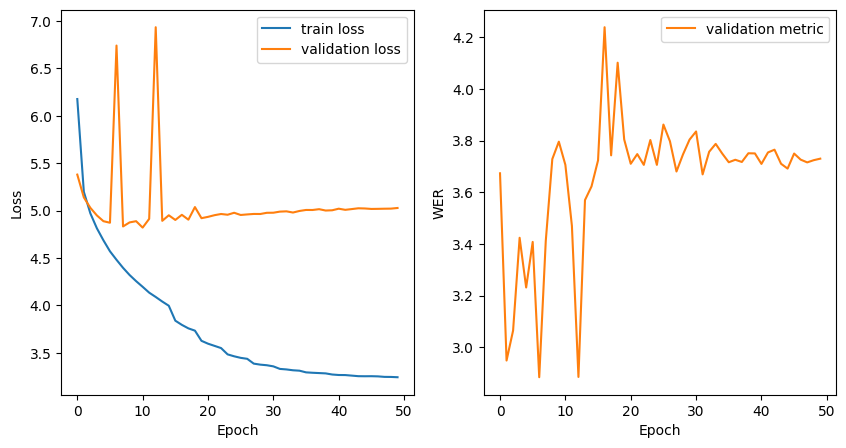

In [ ]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(stop), train_loss_hist, label = 'train loss')
plt.plot(range(stop), valid_loss_hist, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metric_hist)#, label = 'train metric')
plt.plot(valid_metric_hist, label = 'validation metric')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.legend()
plt.show()

# 🔵 **Test**

In [ ]:
model = torch.load('best_model.pt').to(device).eval()

In [ ]:
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 5.060873031616211, WER : 3.760201930999756


# 🔵 **Speech2Text**

In [ ]:
model = torch.load('best_model.pt').to(device).eval()

In [ ]:
def speech2text(model, wavform, sample_rate, vocab, real_text, metric):
  model.eval()

  input = T.Spectrogram(n_fft = 512, hop_length = 128)(wavform).unsqueeze(0)

  tokens = torch.LongTensor([vocab['<sos>']]).unsqueeze(0)
  end = False
  counter = 0
  while(end == False):

    with torch.no_grad():
      new_token = model(input.to(device), tokens.to(device))[:, -1, :]

    index = new_token.argmax(dim = -1)

    if index.item() == vocab['.'] or index.item() == vocab['<eos>']:
      tokens = torch.cat([tokens, torch.LongTensor([index.item()]).unsqueeze(0)], dim = -1)
      end = True

    elif counter == 50:
      end = True

    else:
      tokens = torch.cat([tokens, torch.LongTensor([index.item()]).unsqueeze(0)], dim = -1)
      counter += 1

  text = ''.join([vocab.get_itos()[idx] for idx in tokens.squeeze().tolist()])
  text = text.replace('<sos>', '')
  text = text.replace('<eos>', '')
  real_text = ' '.join(tokenizer(real_text))

  display(Audio(wavform, rate = sample_rate))
  display(text)
  print()
  display(real_text)
  print()
  display(metric([text], [real_text]))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
wavform, sample_rate, real_text, _ = test_set(363)
speech2text(model, wavform, sample_rate, ch_vocab, real_text, metric)

'the the the the the the the the the the the the th'

'thus in 1813 the exaction of jail fees had been forbidden by law ,'

tensor(0.9286, device='cuda:0')